---
# Exploration 05 : 인공지능과 가위바위보 하기
---


## 1. Module Import

추가적인 설명이 필요없는, 지금까지 사용해온 익숙한 필수적인 모듈들을 미리 호출합니다.

In [1]:
# 앞으로 사용 할 기본적인 모듈들 Import

import tensorflow as tf
from tensorflow import keras               # v
import numpy as np

import matplotlib.pyplot as plt            # v
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2.5)
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Google Drive - Colab  연동을 위한 라이브러리 Import

from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Exploration/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# PIL 라이브러리 Import

from PIL import Image
import glob
import os

---
## 2. Function Definition

큰 이미지 사이즈는 처리시간의 오래걸리므로 이미지 사이즈를 적절하게 조절하려합니다.  
LMS에서 진행한 내용과 똑같이 28x28의 사이즈로 진행 할 예정입니다.

In [4]:
# 이후 사용할 resize 함수를 정의

def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

---
## 3. Preprocessing

아래의 두가지를 제외하고는 특별한 전처리는 진행하지 않으려합니다.
1. 이미지 사이즈의 조절(Resize)
2. 정규화(Normalization)

In [5]:
# resize_images() 함수를 이용하여 크기를 조절

# 가위 이미지
image_dir_path = data_dir + "/mook/zzi"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

# 바위 이미지
image_dir_path = data_dir + "/mook/mook"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

# 보 이미지
image_dir_path = data_dir + "/mook/ppa"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

500  images to be resized.
500  images resized.
가위 이미지 resize 완료!
500  images to be resized.
500  images resized.
바위 이미지 resize 완료!
500  images to be resized.
500  images resized.
보 이미지 resize 완료!


## 4. Load train data [ with Normalization ]

Train dataset을 불러온 후 정규화 하려 합니다.

In [6]:
def load_data(img_path, number_of_data=1500):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/zzi/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/mook/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/ppa/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = data_dir + "/mook"
(x_train, y_train)=load_data(image_dir_path)


학습데이터(x_train)의 이미지 개수는 1500 입니다.


** 최초 300개로 진행했으나, 오버피팅 극복을 위해 데이터의 다양성을 늘렸습니다.

데이터가 잘 들어왔는지 확인해보도록 하겠습니다.

라벨:  0


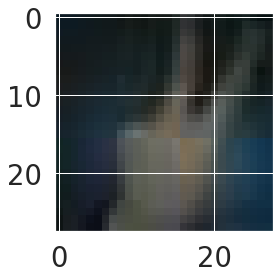

In [7]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

0번째 index에 가위가 label=0 으로 잘 준비되어있음을 확인했습니다. (가위=0 바위=1 보=2)  
데이터들을 한번 살펴보겠습니다.

In [8]:
print('최소값:',np.min(x_train), ' 최대값:',np.max(x_train))

최소값: 0  최대값: 178


입력값(x_train)의 최소값은 0이고 최대값은 178이네요.  
아마 보통 기대되는 값은 0~255일테니 값을 0과 1사이의 값으로 정규화하기 위해 255로 나누도록 하겠습니다.


In [9]:
# 정규화

x_train_norm = x_train/255.0   # 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (1500, 28, 28, 3)
y_train shape: (1500,)


In [10]:
print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))

최소값: 0.0  최대값: 0.6980392156862745


정규화가 잘 이뤄진 것을 확인 했습니다.

---
## 5. Deep learning network design

In [11]:
'''
# 딥러닝 네트워크 설계1
n_channel_1=16
n_channel_2=32
n_dense=64
n_train_epoch=15

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()
'''

"\n# 딥러닝 네트워크 설계1\nn_channel_1=16\nn_channel_2=32\nn_dense=64\nn_train_epoch=15\n\nmodel=keras.models.Sequential()\nmodel.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))\nmodel.add(keras.layers.MaxPool2D(2,2))\nmodel.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))\nmodel.add(keras.layers.MaxPooling2D((2,2)))\n\nmodel.add(keras.layers.Flatten())\nmodel.add(keras.layers.Dense(n_dense, activation='relu'))\nmodel.add(keras.layers.Dense(3, activation='softmax'))\n\nmodel.summary()\n"

최초 LMS에서 제시해준 모델로는 0.3정도밖에 안되는, 만족할만한 accuracy를 얻을 수 없었습니다.  
그에 대한 해결 방법으로 layer를 추가하고 hyperparameter를 조절하는 방법을 택했습니다.(+학습데이터 증가)

In [12]:
# someone / reference - https://velog.io/@ja2y5ung

n_channel_1=64
n_channel_2=128
n_channel_3=256
n_dense=516

model = keras.models.Sequential()

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 256)       

---
## 6. Learning

In [13]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

result = model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
47/47 [==============================] - 6s 109ms/step - loss: 0.8954 - accuracy: 0.5400
Epoch 2/10
47/47 [==============================] - 5s 107ms/step - loss: 0.3237 - accuracy: 0.8720
Epoch 3/10
47/47 [==============================] - 5s 106ms/step - loss: 0.1567 - accuracy: 0.9473
Epoch 4/10
47/47 [==============================] - 5s 106ms/step - loss: 0.0558 - accuracy: 0.9833
Epoch 5/10
47/47 [==============================] - 5s 108ms/step - loss: 0.0288 - accuracy: 0.9907
Epoch 6/10
47/47 [==============================] - 5s 106ms/step - loss: 0.0325 - accuracy: 0.9913
Epoch 7/10
47/47 [==============================] - 5s 108ms/step - loss: 0.0198 - accuracy: 0.9967
Epoch 8/10
47/47 [==============================] - 5s 107ms/step - loss: 0.0094 - accuracy: 0.9980
Epoch 9/10
47/47 [==============================] - 5s 109ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 5s 109ms/step - loss: 0.0039 - accuracy: 1.0000

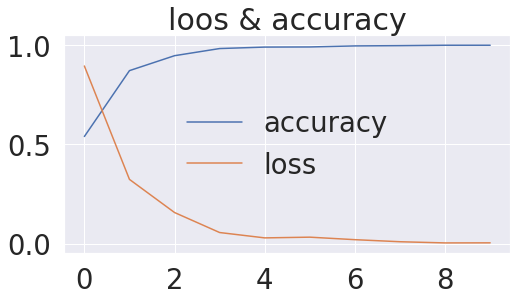

In [14]:
def result_plot(result):
    train_acc = result.history['accuracy']
    train_loss = result.history['loss']

    epochs_range = range(10)

    plt.figure(figsize=(8, 4))

    plt.plot(epochs_range, train_acc, label='accuracy')
    plt.plot(epochs_range, train_loss, label='loss')
    plt.legend(loc='center')
    plt.title('loos & accuracy')

    plt.show()

result_plot(result)

진행됨에 따라 loss가 0에 가깝게 낮아지고, accuracy가 1에 가깝게 수렴함을 볼 수 있습니다!  
이로써 학습이 완료됐으니 test를 준비하도록 하겠습니다.

---
## 7. Load test data [ with Normalization ]

이전 train img와 동일하게 test img에 대해서도 resize를 진행합니다.

In [15]:
image_dir_path = data_dir + "/mook/zzi_test"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

image_dir_path = data_dir + "/mook/mook_test"
resize_images(image_dir_path)

print("주먹 이미지 resize 완료!")

image_dir_path = data_dir + "/mook/ppa_test"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
100  images to be resized.
100  images resized.
주먹 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!


마찬가지로 test dataset을 불러오고 정규화를 진행합니다.

In [16]:
def load_data2(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/zzi_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/mook_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/ppa_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = data_dir + "/mook"
(x_test, y_test)=load_data2(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [17]:
print('최소값:',np.min(x_test_norm), ' 최대값:',np.max(x_test_norm))

최소값: 0.0  최대값: 0.6627450980392157


test data에 대해서도 정규화가 잘 이루어졌습니다.

---
## 8. Evaluation

In [18]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 1.8409 - accuracy: 0.6133 - 399ms/epoch - 40ms/step
test_loss: 1.8408657312393188 
test_accuracy: 0.6133333444595337


처음 얻었던 accuracy 0.3에서, 0.6이 넘는 목표치까지 도달했습니다!

---
## 9. Discussion

1. 처음 이미지를 이용한 프로젝트였는데 준비하는 과정부터 해결하는 과정까지 이전 주가예측 프로젝트보다 재미있었다.
2. code에 대한 두려움 극복. python은 여전히 어렵지만 매번 익숙해지고 있으며 앞으로도 더 노력할 예정이기 때문에 더이상 걱정하지 않으려 한다.
3. 구글링을 통해 목표치에 도달하기 위한 과정에서 LMS에서 배운 것 이상의 학습을 할 수 있었다. 내부적으로 어떤식으로 연산이 이루어지는지는 여전히 모호하지만 layer에 대한 개념은 확실하게 이해 할 수 있었다.
4. 평가지표(목표치)를 맞추기 위해 아래와 같은 과정을 걸었다.
  1. train data 늘리기
  2. layer 추가
  3. 이미지의 특징 수 늘리기
  4. test data 정제(단색배경/근접촬영)
5. 정말 다양한 train 사진들을 사용하며, 마지막으로 test 사진을 다시 찍고난 후 느낀게 준비된 입력 data의 질(피사체의 거리나 방향 등)이 굉장히 중요한 사항이었던 것 같다. 사실 만족할만한 accuracy를 얻기 위해 몇번의 재실행을 거쳤지만, 확실히 매 스텝마다 accuracy는 꾸준히 증가했다.
6. 진행 중 코드꼬임(공유된 어떤 이미지 파일은 png라서 이걸 수정하다가..)이나 코드손실(layer를 추가하고 파라메터 값을 바꾸면서 시도해보다가 에러가 발생했는데 되돌릴 이전 소스코드를 잃어버려서..) 등의 프로젝트 외적인 문제를 너무 많이 겪어서 고통받았다.  
뿐만아니라 시작하기 전엔 점점 올라가는 accuracy를 제시하며 레포트를 예쁘고 보기좋게 작성하려 했는데, 그러한 과정들에 대해서 코드 손실로 인해 적절하고 명확하게 작성하지 못한 점이 아쉬웠다.  
산출물에 대한 적절한 관리가 필요하다는 것을 느꼈고, 앞으로 진행 하는 프로젝트들에 대해서 이부분을 좀 더 신경써서 작성해야겠다.


---